In [10]:
import sys
sys.path.append('../../PI_GP_regressor') 

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_heat_equation import gram_Matrix_jax,k_ff_jax, k_fu_jax, k_uf_jax, k_uu_jax
import numpy as np


In [15]:
# first we put the kernel parts into a list
kernel_list = [gram_Matrix_jax, k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
#then we define the parameters for the kernel
hyperparameters = ["l_x", "sigma_f","l_t", "alpha"]
#now we can define our model. The model needs the kernel list and the hyperparameters, aswell as the timedependence
model_heat_equation = PhysicsInformedGP_regressor(kernel_list,timedependence=True, params=hyperparameters)
model_heat_equation.set_name_kernel("Wave_equation")
#now we create the training data and a validation set
n_training_points = 20
noise = [1e-8,1e-8]
model_heat_equation.set_training_data("heat_data_paper.csv ",n_training_points, noise)

n_validation_points = 1000  #for calculating the MSE
model_heat_equation.set_validation_data(n_validation_points)

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\final_examples\heat_equation\../../PI_GP_regressor\main_class.py:801: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\final_examples\heat_equation\../../PI_GP_regressor\main_class.py:811: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\final_examples\heat_equation\../../PI_GP_regressor\main_class.py:842: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\final_examples\heat_equation\../../PI_GP_regressor\main_class.py:852: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


Now we can train the model. We can choose different methods for the training.   
  -CG: conjugate gradient --- fast but often not very accurate    
  -TNC: truncated Newton --- slower but more accurate     
  -L-BFGS-B: limited memory BFGS --- fast and accurate (not always for some reason)   

generally TNC is the best choice

In [27]:
#for the training we first need to define the initial parameters for the restarts
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lt
    theta_initial[3] = rng.uniform(0, 3, 1)               #c
    return theta_initial

n_restarts = 400; n_threads = 8
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-7}
model_heat_equation.train("TNC",n_restarts, n_threads,opt_params_dict)

 c:\Users\Razer\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning:A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
100%|██████████| 400/400 [02:47<00:00,  2.39it/s]


     fun: 15.291841506958008
     jac: array([ -1.1435547, -27.652588 , -40.301636 , 296.00824  ], dtype=float32)
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 94
     nit: 12
  status: 1
 success: True
       x: array([0.29711248, 0.26530154, 0.41890516, 1.00234168])


In [28]:
n_test_points = 100
x_star, t_star = np.meshgrid(np.linspace(0, 1, n_test_points), np.linspace(0, 1, n_test_points))
X_star = np.hstack((x_star.reshape(-1, 1), t_star.reshape(-1, 1)))
model_heat_equation.predict_model(X_star)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


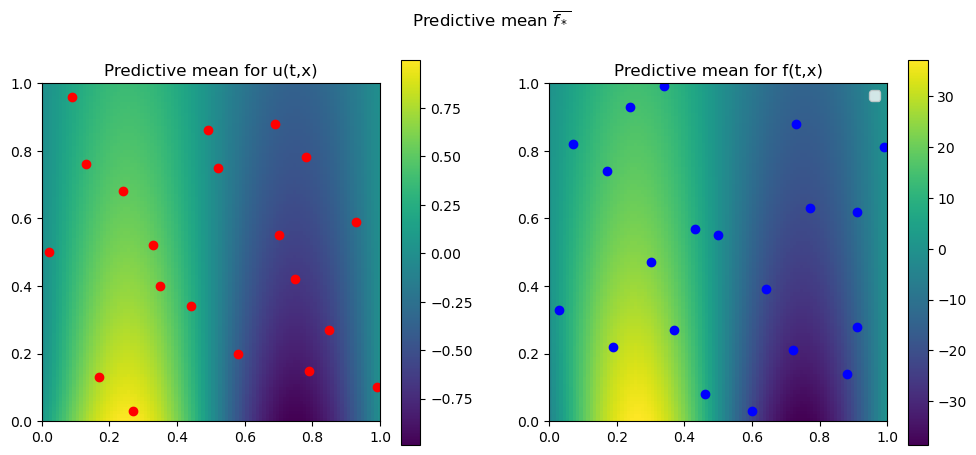

In [30]:
model_heat_equation.plot_prediction(X_star, "Predictive mean $\\overline{ f_*}$","predictive_mean.png",True)

-----------------------------------------------
GP with kernel: 
Training data: (20, 2)
Training targets: (40, 1)
Hyperparameters: {'l_x': 0.3171686437511146, 'sigma_f': 0.9191386796364254, 'l_t': 0.33199035031990265, 'alpha': 1.1788881163236322}
Log marginal likelihood: 87.497802734375
Mean squared error: {'u': 0.016367048025131226, 'f': 63.58355712890625}
-----------------------------------------------



 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\final_examples\heat_equation\../../PI_GP_regressor\main_class.py:565: RuntimeWarning:invalid value encountered in sqrt
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\final_examples\heat_equation\../../PI_GP_regressor\main_class.py:573: RuntimeWarning:invalid value encountered in sqrt


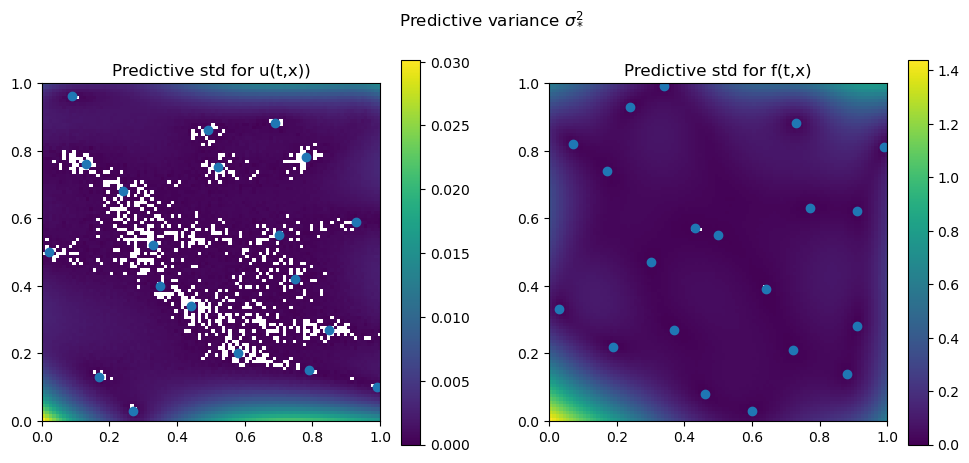

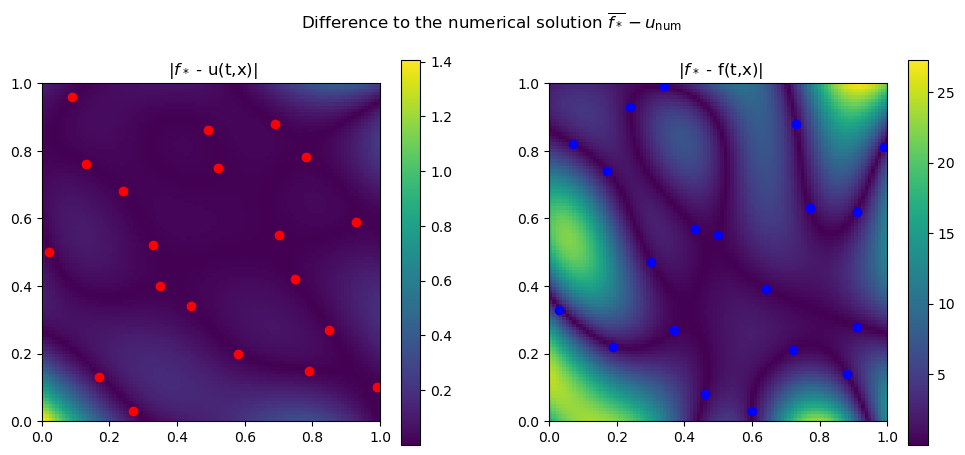

In [26]:
model_heat_equation.error()
print(model_heat_equation)
model_heat_equation.plot_variance(X_star, "Predictive variance $\\sigma_*^2$","predictive_variance.png")
model_heat_equation.plot_difference("Difference to the numerical solution $\\overline{ f_*} - u_{\\mathrm{num}}$","difference.png")

We can now do the same with the GPy library with a non modified kernel(we just use the RBF kernel with ARD)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


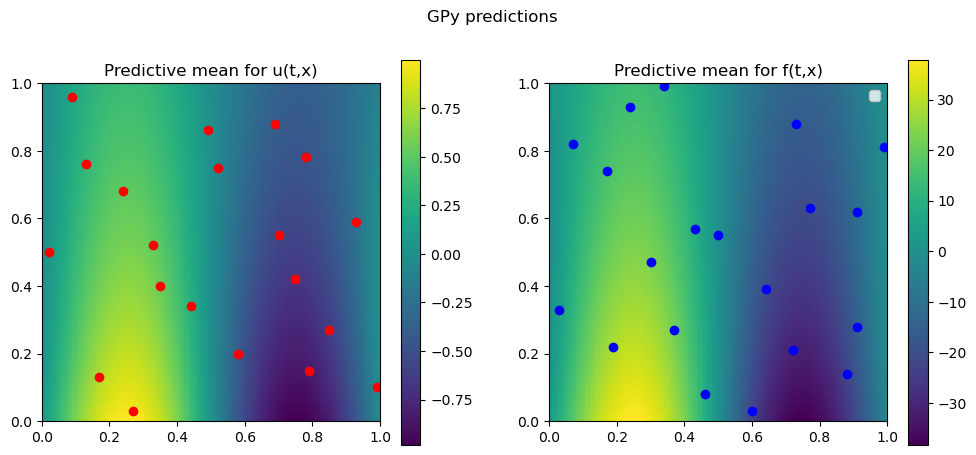

In [31]:
model_heat_equation.use_GPy(X_star,"GPy_predictive_mean",True)


MSE_u:  0.00022015108662546296
MSE_f:  0.14588936241859052


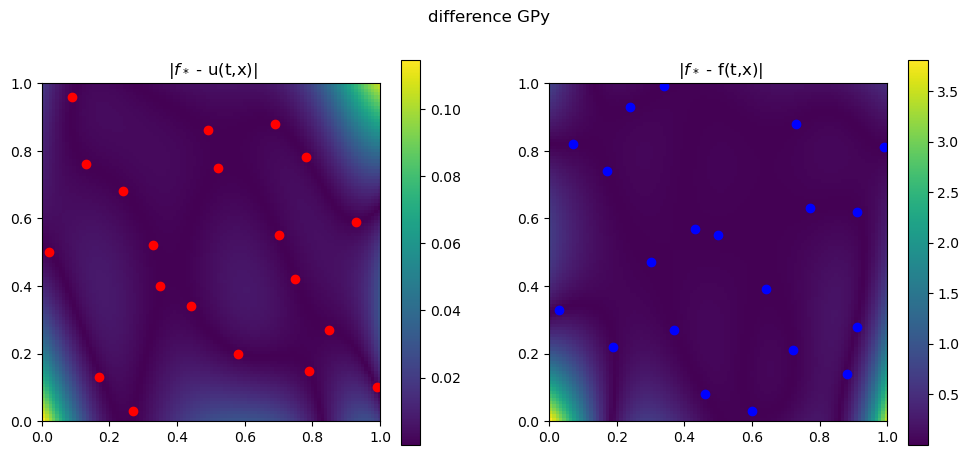

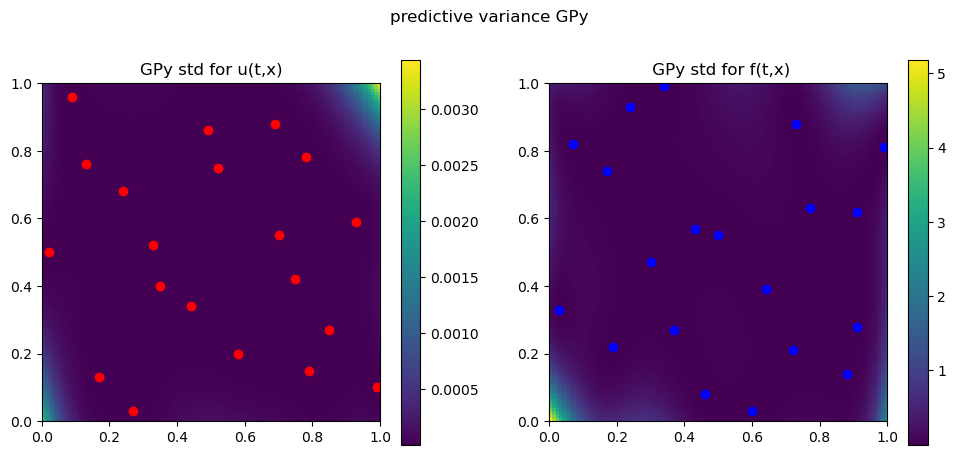

In [24]:
model_heat_equation.plot_difference_GPy("difference GPy ", "GPy_difference.png")
model_heat_equation.plot_variance_GPy("predictive variance GPy ", "GPy_variance.png")